<a href="https://colab.research.google.com/github/ozsilahtar/RegML/blob/master/6_S093%2C_Day_1_Finetune_Flux_Replicate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to use a Python Notebook

To run and modify the notebook, in the top left go to `File` -> `Save a copy in Drive`.

Useful shortcuts:
- `Shift + enter`: `runs the cell`

# Additional Resources about finetuning:

More in depth fine tuning explanation:
- [LORA finetuning](https://civitai.com/articles/4/make-your-own-loras-easy-and-free) -- **what we do today**
- [Finetuning Flux](https://replicate.com/blog/fine-tune-flux)
- [Dreambooth](https://dreambooth.github.io/)

In [ ]:
#@title 0.A Install replicate library
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 2.0 MB/s eta 0:00:00


# 0.B Setup Replicate

In [ ]:
# TODO: add your API key
# REPLICATE_API_KEY = "<FILL_THIS_IN>" # You will find this on your Replicate Profile (https://replicate.com/account/api-tokens)
REPLICATE_API_KEY =

In [ ]:
import os
import replicate
from IPython.display import Image, display

# Make the API Key available
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_KEY

In [ ]:
#@title 0.C Test the image generation model

# TODO: play with the prompt and
# TODO: try generating your subject. Does it work?

output = replicate.run(
    "black-forest-labs/flux-dev",
    input={
        "prompt": "A photo of Djeny dog in a space station",
        "num_inference_steps": 28, # typically need ~30 for "dev" model. Less steps == faster generation, but the quality is worse
        "guidance_scale": 7.5,     # how much attention the model pays to the prompt. Try different values between 1 and 50 to see
        "model": "dev",        # after fine-tuning you can use "schnell" model to generate images faster. In that case put num_inference_steps=4
    }
)

generated_img_url = str(output[0])
print(f"Generated image URL: {generated_img_url}")
display(Image(url=generated_img_url))

# 1. Overview of the finetuning a text to image model process

The first and most important thing to care about when training a custom image generation model, is the data. If you have a bad dataset that you are training on, it does not matter what model or how much compute you throw at the problem, your output model will still not perform the way that you want it to.

For image generation, we don't actually need a lot of data to add a new concept or style to the model.

**Image requirements**:
- \>= 5 images (more is always better, usually datasets are between 20-1000 images)
- Avoid low quality images, i.e. blurry or low (<256 px) resolution
- Avoid images with weird aspect ratios (anything more than 2:1, ie 1024x512px)
- Don't worry about getting 4k or super high resolution images, they will be downscaled to ~1024px per side when training
- Assemble these into a ZIP file that you make available via Google Drive


When training a model, you will typically either be training the model to understand a new entity or new style. Because of this, you will want a **TRIGGER WORD** that lets the model know you are trying to evoke that concept. That way the model will keep its previous understanding of concepts while also having a new one added to it. Because we dont want to overwrite existing concepts, the **TRIGGER WORD** should be a unique/unseen word.

Examples:
- `SUNDAI`
- `tr1gg3r_w0rd`.
- `DJENNYDOG`

In [ ]:
#@title 1.A Create the model repository

# Here we are setting up the repository in replicate where the model will go once we have trained it

import replicate
from replicate.exceptions import ReplicateError

# You can see your username on replicate in the top left corner.

# NOTE: we use sundai-club account name because you logged via Sundai org
replicate_username = "sundai-club"
# TODO: Name of your fintuned model
# Consult: https://replicate.com/models to see what names have already been used. Do not collide with an existing name
# Should be one word, no spaces. Can use underscores to combine words
# finetuned_mode_name = "<FILL_THIS_IN_WITH_A_UNIQUE_VALUE>"
finetuned_mode_name = # Name of your model goes here

try:
  model = replicate.models.create(
      owner=replicate_username,
      name=finetuned_mode_name,
      visibility="public",  # or "private" if you prefer
      hardware="gpu-t4",  # Replicate will override this for fine-tuned models
      description="A fine-tuned FLUX.1 model",
  )
  print(f"Model created: {model.name}")
except ReplicateError as e:
  if "already exists" in e.detail:
    print("Model already exists, loading it.")
    model = replicate.models.get(f"{replicate_username}/{finetuned_mode_name}")
  else:
    raise e

print(f"Model URL: https://replicate.com/{model.owner}/{model.name}")

### 1.B Collect your dataset

Based off the slide's guidance, assemble a ZIP of images and make them available by dragging into the file browser in Colab.

Place it at the root of the colab notebook.

In [ ]:
#@title 1.C Train the model

# TODO: upload your dataset and put its name here
dataset_path = "dataset.zip"
trigger_word = # TODO: pick your trigget word
steps = 1000 # keep the number of steps at 1000

training = replicate.trainings.create(
    version="ostris/flux-dev-lora-trainer:4ffd32160efd92e956d39c5338a9b8fbafca58e03f791f6d8011f3e20e8ea6fa",
    input={
        "input_images": open(dataset_path, "rb"),
        "steps": 1000,
    },
    trigger_word=trigger_word,
    destination=f"{model.owner}/{model.name}"
)

print(f"Training started: {training.status}")
print(f"Training URL: https://replicate.com/p/{training.id}")

#### TODO: Open the Training URL to follow along with Training
- The page should look like: 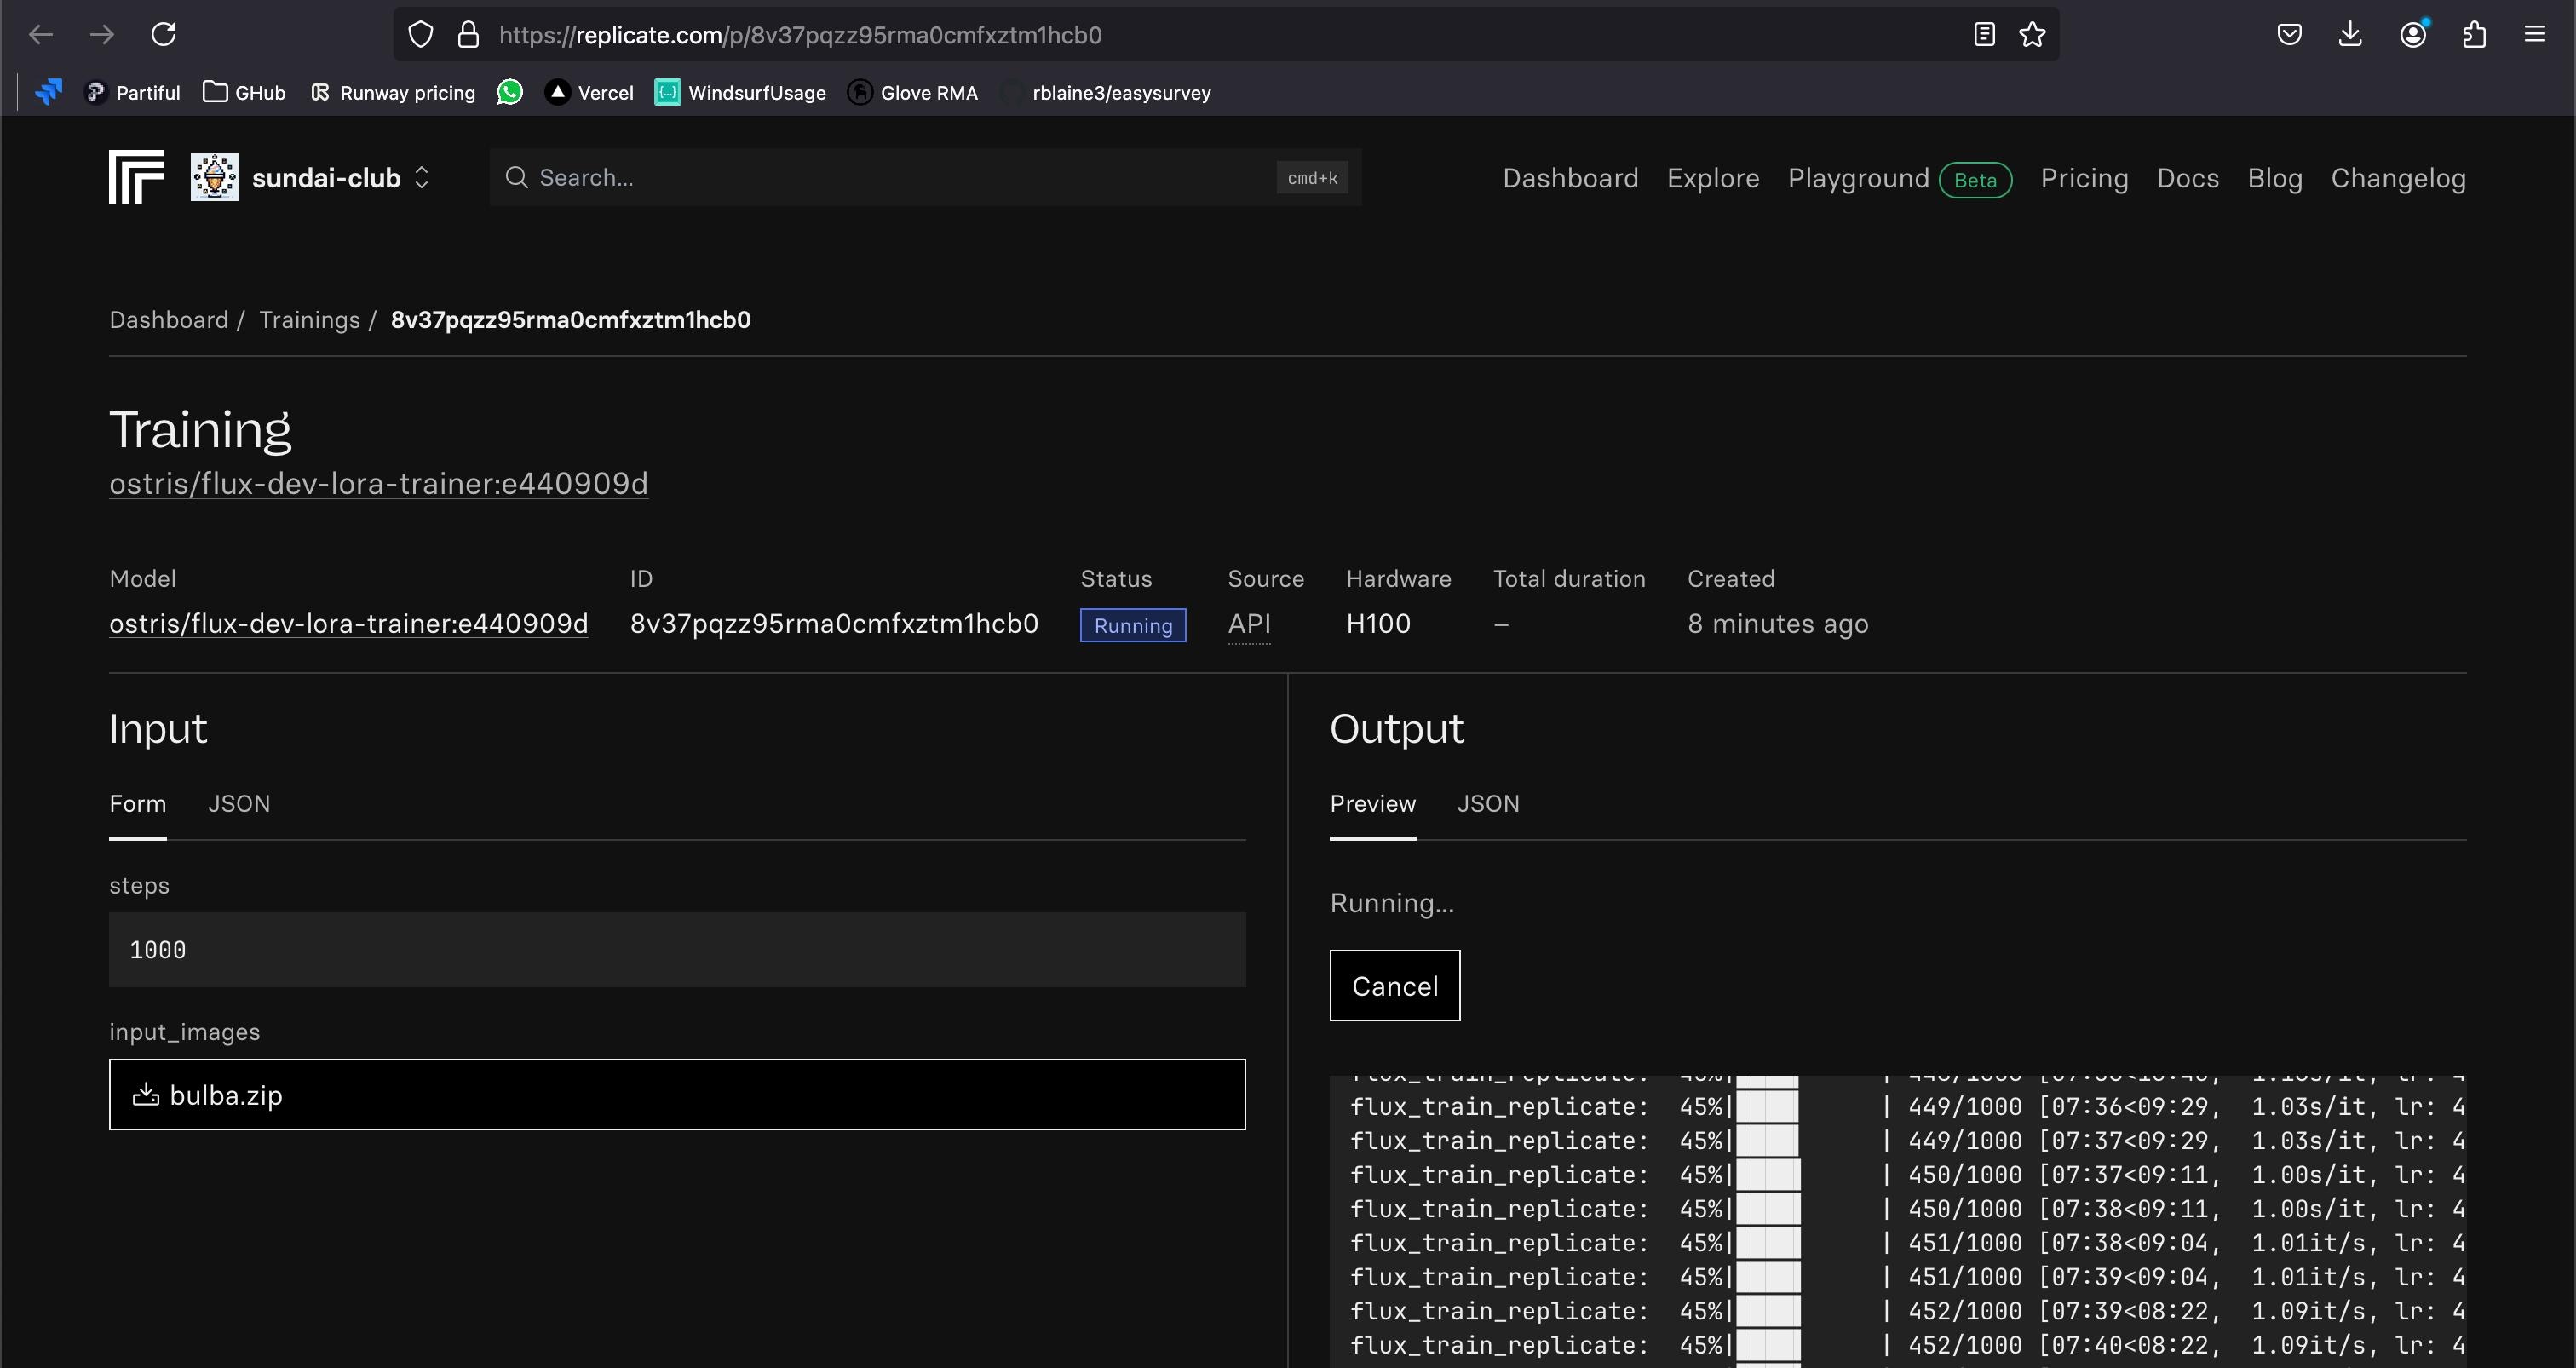
- This should take ~20 minutes
  - You will be given an error message if your setup is not correct
- While you wait, fill in your Model's README so other's know what TRIGGER_WORD is used, where your DataSet came from, and how many steps you are training for. See [here](https://replicate.com/sundai-club/flux-bulbasaur/readme) for an example README.

In [ ]:
#@title 1.D Test your fine-tuned model

latest_version = model.versions.list()[0]
# NOTE: you can also find a full version link at the training page

# TODO: try generating you subject. Does it look like them?
# Try helping your model by providing additional subject description

output = replicate.run(
    latest_version,
    input={
        "prompt": f"{trigger_word} is now wrapped in a small blanket, pretending to be asleep on the couch, still with visible cookie crumbs around its mouth. A confused-looking human mom is standing in the kitchen doorway, looking at the mess. The dog has one eye slightly open, peeking. Cute cartoonish style, warm colors.",
        "num_inference_steps": 28, # typically need ~30 for "dev" model. Less steps == faster generation, but the quality is worse
        "guidance_scale": 7.5,     # how much attention the model pays to the prompt. Try different values between 1 and 50 to see
        "model": "dev",            # after fine-tuning you can use "schnell" model to generate images faster. In that case put num_inference_steps=4
    }
)

generated_img_url = str(output[0])
print(f"Generated image URL: {generated_img_url}")
display(Image(url=generated_img_url))

#### TODO: Add an example to your Replicate Model page
- See [here](https://replicate.com/sundai-club/flux-bulbasaur/examples) for an Example. This must be created via the Replicate "Playground"


In [ ]:
#@title 1.E Faster Generation test

# TODO: play with the paramaeters of the model to get faster generation of the subject
# HINT: read the comments of the input parameters

latest_version = model.versions.list()[0]
output = replicate.run(
    latest_version,
    input={
        "prompt": f"{trigger_word} black dog in a drwing vector style as a favicon",
        "num_inference_steps": 28,  # typically need ~30 for "dev" model. Less steps == faster generation, but the quality is worse
        "guidance_scale": 7.5,     # how much attention the model pays to the prompt. Try different values between 1 and 50 to see
        "model": "dev",        # after fine-tuning you can use "schnell" model to generate images faster. In that case put num_inference_steps=4
    }
)

generated_img_url = str(output[0])
print(f"Generated image URL: {generated_img_url}")
display(Image(url=generated_img_url))

In [ ]:
#@title 2. (Extra points) Use an LLM to generate a 3 panel comic series

!pip install pydantic openai

## TODO: Add your GitHub Token to allow LLM usage

In [ ]:
GITHUB_TOKEN = # TODO: Can be obtained from: https://github.com/marketplace/models/azure-openai/gpt-4o/playground

In [ ]:
import json
from pydantic import BaseModel
from openai import OpenAI

client = OpenAI(
    base_url="https://models.inference.ai.azure.com",
    api_key=GITHUB_TOKEN,
)

# TODO: adjust the promp for your style and subject!

In [ ]:
# TODO: adjust the promp for your style and subject!

# Note: responce_format is better way of enfocing structured output, however it
#       is still not supported in GitHub models. If you have an OpenAI key, you
#       can use these docs:
#         https://platform.openai.com/docs/guides/structured-outputs?lang=python

def generate_comics(user_prompt: str):
    """
    Generate comics story with image prompts and captions in JSON format

    Args:
        user_prompt (str): The story prompt from user

    Returns:
        dict: JSON formatted comics data
    """

    # System prompt for consistent output formatting
    system_prompt = """
    Create a 3-panel comic story about a dog's adventure. For each panel, provide:
    1. An image generation prompt that includes 'DJENNDOG black dog' and ends with 'cartoonish style, warm colors'
    2. A caption that refers to the dog as 'Djeny'

    Format the output as JSON with this structure:
    {
        "comics": [
            {
                "prompt": "Image generation prompt here",
                "caption": "Caption text here"
            }
        ]
    }
    """

    response = client.chat.completions.create(
        model="gpt-4o",
        response_format={ "type": "json_object" },
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
    )

    # Parse response to JSON
    story_json = json.loads(response.choices[0].message.content)
    return story_json

comics = generate_comics("An adventrure in a concert")
print(json.dumps(comics, indent=2, ensure_ascii=False))

In [ ]:
# Here we generate images with the given description
# TODO: can you make it faster? Hint: remember what you've done in 1.D

img_urls = []
for img_description in comics["comics"]:
  output = replicate.run(
    latest_version,
    input={
        "prompt": img_description["prompt"],
        "num_inference_steps": 28,  # typically need ~30 for "dev" model. Less steps == faster generation, but the quality is worse
        "guidance_scale": 7.5,     # how much attention the model pays to the prompt. Try different values between 1 and 50 to see
        "model": "dev",        # after fine-tuning you can use "schnell" model to generate images faster. In that case put num_inference_steps=4
    }
  )

  generated_img_url = str(output[0])
  img_urls.append(generated_img_url)

In [ ]:
# Do a pretty visualization

from IPython.display import HTML

# HTML template for responsive image grid
html_template = '''
<div style="display: flex; flex-wrap: wrap; justify-content: space-around; gap: 20px;">
    {}
</div>
'''

# HTML template for each image and caption
image_template = '''
<div style="flex: 0 1 300px; text-align: center; margin-bottom: 20px;">
    <img src="{}" style="max-width: 100%; height: auto; border-radius: 8px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
    <p style="margin-top: 10px; font-style: italic; color: #888;">{}</p>
</div>
'''

# Combine all images and captions
image_elements = []
for url, caption in zip(img_urls, [ b["caption"] for b in comics["comics"] ]):
    image_elements.append(image_template.format(url, caption))

# Display the final HTML
display(HTML(html_template.format(''.join(image_elements))))